# Fauna data LSTM

# Import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
import fpmodules.tools as tools
from torch.nn.functional import softmax, sigmoid

*** FP-modules version 2.10.13 ***


# Load data

In [2]:
EVENTS_CACHE_PATH = os.path.expanduser("~/EventCache")
filename_data = os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/dca6327d8fa8_20210330_raw_20210330T152242Z_ds_5_data.npy')
filename_labels = os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/dca6327d8fa8_20210330_raw_20210330T152242Z_ds_5_labels.npy')

data = np.load(filename_data)[:,1]
labels = np.load(filename_labels)[:,1]

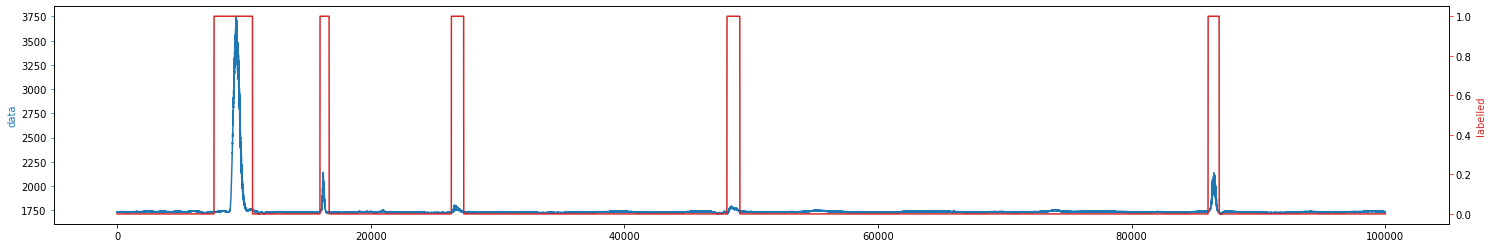

In [3]:
# plot
fig, ax1 = plt.subplots()
fig.set_figwidth(25)
color = 'tab:blue'
ax1.set_ylabel('data', color=color)
ax1.plot(data[800000:900000], color=color)
ax1.tick_params(axis='y', color=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('labelled', color=color)
ax2.plot(labels[800000:900000], color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

Data-preprocessing. Get the data and the labels separate from a single dataframe.

Transform and scale output

In [ ]:
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#mm = MinMaxScaler()
#ss = StandardScaler()

#X_ss = ss.fit_transform(X)
#y_mm = mm.fit_transform(y)

In [ ]:
def split_datasets(data, labels):
    # 80 % for training, 10 % for validation, 10 % for testing
    train_index = int(len(data)*0.8)
    valid_index = train_index + int(len(data)*0.1)

    X_train = data[0:train_index]
    X_test = data[train_index:valid_index]
    X_valid = data[valid_index:]

    y_train = labels[0:train_index]
    y_test = labels[train_index:valid_index]
    y_valid = labels[valid_index:]

    return X_train, X_test, X_valid, y_train, y_test, y_valid

def format_datasets(X_train, X_test, X_valid, y_train, y_test, y_valid):
    X_train = np.reshape(X_train,(X_train.size,1)).astype(np.int32)
    X_test = np.reshape(X_test,(X_test.size,1)).astype(np.int32)
    X_valid = np.reshape(X_valid,(X_valid.size,1)).astype(np.int32)
    y_train = np.reshape(y_train,(y_train.size,1)).astype(np.int16)
    y_test = np.reshape(y_test,(y_test.size,1)).astype(np.int16)
    y_valid = np.reshape(y_valid,(y_valid.size,1)).astype(np.int16)

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_valid_tensors = Variable(torch.Tensor(X_valid))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_valid_tensors = Variable(torch.Tensor(y_valid))
    y_test_tensors = Variable(torch.Tensor(y_test))

    # shape is (batch size, sequence length, input size)
    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_valid_tensors_final = torch.reshape(X_valid_tensors,   (X_valid_tensors.shape[0], 1, X_valid_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

    return X_train_tensors_final, X_test_tensors_final, X_valid_tensors_final, y_train_tensors, y_test_tensors, y_valid_tensors

def data_loader():
  insect_files = os.listdir(os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/insects'))
  insect_filename_data = []
  insect_filename_labels = []

  for file in insect_files:
      if file.split('_')[-1] == 'data.npy':
        insect_filename_data.append(os.path.join(os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/insects')), file)
        insect_filename_labels.append(os.path.join(os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/insects')), file[0:-8] + 'labels.npy')

  for f in range(0, len(insect_filename_data)):
    data = np.load(insect_filename_data[f])[:,1]
    labels = np.load(insect_filename_labels[f])[:,1]

    X_train, X_test, X_valid, y_train, y_test, y_valid = split_datasets(data, labels)
    X_train_tensors_final, X_test_tensors_final, X_valid_tensors_final, y_train_tensors, y_test_tensors, y_valid_tensors = format_datasets(X_train, X_test, X_valid, y_train, y_test, y_valid)
    dict = {
        'X_train': X_train_tensors_final,
        'X_test': X_test_tensors_final,
        'X_valid': X_valid_tensors_final,
        'y_train': y_train_tensors,
        'y_test': y_test_tensors,
        'y_valid': y_valid_tensors
    }
    yield dict

In [6]:
a = 'b_a_abd'

In [7]:
a.split('_')

['b', 'a', 'abd']

In [9]:
files = os.listdir(os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/insects'))


In [15]:
files[0][0:-8]

'dca6327d8fa8_20210330_raw_20210330T152242Z_ds_535419365_'

Define training and test data

In [6]:
data_generator = data_loader()

In [7]:
data = data_generator.__next__()

In [8]:
data.keys()

dict_keys(['X_train', 'X_test', 'X_valid', 'y_train', 'y_test', 'y_valid'])

In [9]:
print("Training Shape", data['X_train'].shape, data['y_train'].shape)
print("Validation Shape", data['X_valid'].shape, data['y_valid'].shape)
print("Testing Shape", data['X_test'].shape, data['y_test'].shape)

Training Shape torch.Size([1982643, 1, 1]) torch.Size([1982643, 1])
Validation Shape torch.Size([247831, 1, 1]) torch.Size([247831, 1])
Testing Shape torch.Size([247830, 1, 1]) torch.Size([247830, 1])


Prepare input for LSTM

# Define model

In [10]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm

        self.linear_out = nn.Linear(hidden_size, num_classes) #fully connected last layer

    def forward(self,x):
        # Propagate input through LSTM
        x, (h, c) = self.lstm(x) #lstm with input, hidden, and internal state
        x = x.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        x = self.linear_out(x) #first Dense
        out = sigmoid(x) #Final Output
        return out

Hyper parameters

In [11]:
num_epochs = 100 # 1000 epochs
learning_rate = 0.1 # 0.001 lr

input_size = 1 # number of features
hidden_size = 10 # number of features in hidden state
num_layers = 2 # number of stacked lstm layers

num_classes = 1 # number of output classes

 Instantiate the class LSTM1 object

In [12]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers) #our lstm class

Loss function and optimizer

In [13]:
criterion = torch.nn.MSELoss()#MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [14]:
for d in data.keys():
    print(d, data[d].shape)

X_train torch.Size([1982643, 1, 1])
X_test torch.Size([247830, 1, 1])
X_valid torch.Size([247831, 1, 1])
y_train torch.Size([1982643, 1])
y_test torch.Size([247830, 1])
y_valid torch.Size([247831, 1])


# Train the model

In [15]:
def get_result(output):
    output[output > 0.5] = 1
    output[output < 0.5] = 0
    return output

In [16]:
# cross

In [ ]:
epoch_training_loss = []
epoch_validation_loss = []
epoch_training_acc = []
epoch_validation_acc = []
no_files = 10
for epoch in range(num_epochs):
  training_loss = 0
  validation_loss = 0
  training_correct = 0
  training_all = 0
  validation_correct = 0
  validation_all = 0

  data_generator = data_loader()

  for file in range(no_files):
      data = data_generator.__next__()

      lstm.eval()
      outputs = lstm.forward(data['X_valid']) #forward pass
      loss = criterion(outputs, data['y_valid'])
      loss.backward() #calculates the loss of the loss function
      validation_loss += loss.item()

      validation_correct += (get_result(outputs) == data['y_valid']).float().sum()
      validation_all += len(data['y_valid'])

      lstm.train()
      outputs = lstm.forward(data['X_train']) #forward pass

      # obtain the loss function
      loss = criterion(outputs, data['y_train'])
      loss.backward() #calculates the loss of the loss function
      training_loss += loss.item()
      training_correct += (get_result(outputs) == data['y_train']).float().sum()
      training_all += len(data['y_train'])

      optimizer.step() #improve from loss, i.e backprop
      optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  validation_acc = 100 * validation_correct / validation_all
  training_acc = 100 * training_correct / training_all
  #if epoch % 10 == 0:
  print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f, , training acc: %1.5f, , validation acc: %1.5f" % (epoch, training_loss, validation_loss, training_acc, validation_acc))

  epoch_validation_loss.append(validation_loss)
  epoch_validation_acc.append(validation_acc)
  epoch_training_loss.append(training_loss)
  epoch_training_acc.append(training_acc)

/home/thoresen/anaconda3/envs/fp_env/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, training loss: 0.52222, validation loss: 0.70746, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 1, training loss: 0.10738, validation loss: 0.35892, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 2, training loss: 0.10754, validation loss: 0.35947, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 3, training loss: 0.10756, validation loss: 0.35955, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 4, training loss: 0.10757, validation loss: 0.35957, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 5, training loss: 0.10757, validation loss: 0.35958, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 6, training loss: 0.10757, validation loss: 0.35958, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 7, training loss: 0.10757, validation loss: 0.35958, , training acc: 98.92401, , validation acc: 96.40319
Epoch: 8, training loss: 0.10757, validation loss: 0.35957, , training acc: 98.92401, , validati

In [ ]:
plt.plot(np.linspace(0, num_epochs-1, num_epochs), epoch_validation_loss, label='validation loss')
plt.plot(np.linspace(0, num_epochs-1, num_epochs), epoch_training_loss, label='training loss')
plt.legend()
plt.show()

# Run the model

Convert data

In [ ]:
df_X_ss = data['X_test']#data.astype(np.int32)

df_X_ss = Variable(torch.Tensor(df_X_ss))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, 1))

Show predictions

In [ ]:
train_predict = lstm(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
data_predict[data_predict > 0.5] = 1
data_predict[data_predict < 0.5] = 0

dataY_plot = data['y_test']

plt.figure(figsize=(10,6)) #plotting
#plt.axvline(x=40000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()